### 1. Decompress input data

In [1]:
%%bash
unzip catdog_data.zip

### 2. Examine input images

In [1]:
%%bash
ls catdog_data/

test
train
validation


In [25]:
%%bash
ls catdog_data/train/*/*|wc -l
ls catdog_data/train/cats/*|wc -l
ls catdog_data/train/dogs/*|wc -l
ls catdog_data/test/*/*|wc -l
ls catdog_data/validation/*/*|wc -l

2000
1000
1000
400
600


### 3. Visualize input images

In [53]:
import numpy as np
import pandas as pd
import random
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
#from ImageDataGenerator import flow_from_directory
from keras.models import Sequential
from keras.models import *
import utils
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import *

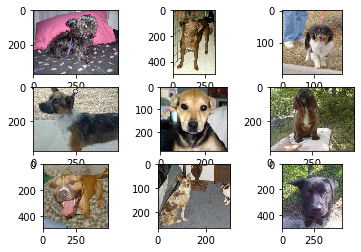

In [54]:
# plot dog photos from the dogs vs cats dataset
# define location of dataset
folder = 'catdog_data/train/dogs/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(3, 3, i+1)
    # define filename
    filename = f"{folder}dog.{str(i)}.jpg"
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

### 4. Pre-process input images
Tutorial here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [55]:
#Specifying the image
Image_Width=256
Image_Height=256
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [56]:
generator = ImageDataGenerator(rotation_range=60, fill_mode='nearest')
train_imgs = generator.flow_from_directory(directory="catdog_data/train", target_size=Image_Size)
val_imgs = generator.flow_from_directory(directory="catdog_data/validation/", target_size=Image_Size)
generator = ImageDataGenerator()
test_imgs = generator.flow_from_directory(directory="catdog_data/test", target_size=Image_Size)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [57]:
type(train_imgs)

keras.preprocessing.image.DirectoryIterator

In [58]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_16 (Bat  (None, 254, 254, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_17 (Bat  (None, 125, 125, 64)    

In [59]:
from tensorflow.keras.optimizers import Adam, SGD

In [60]:
base_model = model

In [61]:
def fitted_model(model: Sequential, lr: float, train_imgs: keras.preprocessing.image.DirectoryIterator, val_imgs: keras.preprocessing.image.DirectoryIterator):
    model.compile(optimizer=Adam(learning_rate=lr), loss="categorical_crossentropy", metrics=["accuracy"])
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.inc.blond.hdf5', verbose=1, save_best_only=True)
    model_history = model.fit(train_imgs, 
                            validation_data=val_imgs,
                            steps_per_epoch=len(train_imgs),
                            validation_steps=len(val_imgs),
                            epochs=10, callbacks=[checkpointer])
    return (model, model_history)

In [62]:
trained_model, history = fitted_model(base_model, 0.001, train_imgs, val_imgs)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 1.4163 - accuracy: 0.5480
Epoch 1: val_loss improved from inf to 1.22761, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 268s 4s/step - loss: 1.4163 - accuracy: 0.5480 - val_loss: 1.2276 - val_accuracy: 0.5700
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.6205
Epoch 2: val_loss improved from 1.22761 to 0.83396, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 290s 5s/step - loss: 0.8125 - accuracy: 0.6205 - val_loss: 0.8340 - val_accuracy: 0.6150
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.6300
Epoch 3: val_loss did not improve from 0.83396
63/63 [==============================] - 337s 5s/step - loss: 0.7428 - accuracy: 0.6300 - val_loss: 0.8512 - val_accuracy: 0.6333
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.6715

In [63]:
base_model.save("dog_cat_adam_10epochs.h5")

### 5. Load the model and test the accuracy using the test data set

In [37]:
from tensorflow.keras.models import load_model 

In [38]:
fitted_model = load_model("dog_cat_adam_10epochs.h5")
res = fitted_model.evaluate(test_imgs, verbose=0)
acc = res[1]
print(acc*100)

66.75000190734863


### 6. Try to augment the train dataset further, thus testing again
related tutorials: https://rasilamichhane.medium.com/image-data-augmentation-with-keras-425068414071

In [65]:
# randomly adjust brightness
generator = ImageDataGenerator(brightness_range = (0.5, 2.0))
train_imgs = generator.flow_from_directory(directory="catdog_data/train", target_size=Image_Size)
val_imgs = generator.flow_from_directory(directory="catdog_data/validation/", target_size=Image_Size)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [66]:
trained_model1, history1 = fitted_model(model, 0.001, train_imgs, val_imgs)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.7070
Epoch 1: val_loss improved from inf to 0.77152, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 343s 5s/step - loss: 0.5836 - accuracy: 0.7070 - val_loss: 0.7715 - val_accuracy: 0.6550
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.7905
Epoch 2: val_loss did not improve from 0.77152
63/63 [==============================] - 320s 5s/step - loss: 0.4544 - accuracy: 0.7905 - val_loss: 0.8165 - val_accuracy: 0.6367
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8440
Epoch 3: val_loss improved from 0.77152 to 0.64420, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 298s 5s/step - loss: 0.3667 - accuracy: 0.8440 - val_loss: 0.6442 - val_accuracy: 0.6783
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8785

In [69]:
res = trained_model1.evaluate(test_imgs, verbose=0)
acc = res[1]
print(round(acc*100, 3))

73.0
